Sanity check on current weight maps. We'll try to recreate the results of Dai et al. (2015) first to make sure we're estimating the correct number of sources

In [1]:
# Import necessary packages
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
#from scipy.integrate import quad
import matplotlib.pyplot as plt
from astropy.io import fits
import os

In [32]:
# Initalize python stuff

figsize = (10,6)
dpi = 170
fontsize = 10

# Configure parameters
plt.rcParams.update({'font.size': fontsize, 'figure.figsize': figsize, 'figure.dpi': dpi})

# Default tick label size
plt.style.use('default')
plt.rcParams['text.usetex'] = False
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1

plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['axes.linewidth'] = 1

In [7]:
# Read in AGN table:
path = '/Users/bbonine/ou/research/corr_func/data/'
cat = path + 'agntable_total.txt'
field = np.loadtxt(cat, dtype = str,delimiter = None, skiprows = 1, usecols=(15) , unpack = True)
x,y = np.loadtxt(cat, delimiter = None, skiprows = 1, usecols=(16,17) , unpack = True)

#Get rid of any duplicates:
field_list = np.unique(field)
len(field_list)

739

In [15]:
# Read in the flux limit file: 

lim = path + 'fluxlimit.txt'
exp, fluxlim = np.loadtxt(lim,skiprows = 1, unpack = True)
exp = np.power(10,exp) #exposure time in log units; convert

# Interpolate 
func1 = InterpolatedUnivariateSpline(exp,fluxlim) 


In [104]:
# Begin looping through fields

runs = 1
for i in range(410,411):
    pixel_angle_sec = (47.1262 / 20)**2 # [square arcseconds]
    pixel_angle_deg = (pixel_angle_sec / 3600**2)
    pix_scale = 47.1262 / 20 # arcseconds / pixel
    # Integrate the broken power law from the paper:
    a = 1.34
    b = 2.37 # +/- 0.01
    f_b = 3.67 * 10 ** (-15) # erg  cm^-2 s^-1
    k = 531.91*10**14 # +/- 250.04; (deg^-2 (erg cm^-2 s^-1)^-1)
    s_ref = 10**-14 # erg cm^-2 s^-1

    def f3(x):
        return (1/(-a+1))*(1/s_ref)**(-a)*k*(x**(-a+1))

    def f4(x):
        return (1/s_ref)**(-b)*k*(f_b/s_ref)**(b-a)*(1/(-b+1))*(x**(-b+1))
    
    # Read in the relevant exposure map:
    here = np.where(field == field_list[i])
    
    if os.path.isfile(path  + field[here][0] +'/expo.fits') == True:
        expmap = path + field[here][0] +'/expo.fits'
        print("Exposure map located")

        
        
    # Read in exposure map with astropy
        hdu_list = fits.open(expmap)
        image_data = hdu_list[0].data
        hdu_list.close()
        exp_map_1d =  image_data.ravel() #Conver exposure map to 1D array for later
        
      # Save reference pixel value for later
        ref_flux =  image_data[500,500]
    
        # Use the interpolated function to extract flux limit based off reference flux
        flux_lim = (func1(ref_flux))
    
        # Find the flux limit for each pixel:
        fluxlimit = np.zeros(len(exp_map_1d))
        for j in range(0,len(fluxlimit)):
            fluxlimit[j] = (func1(exp_map_1d[j]))
            
        fluxlimit_1d = np.asarray(fluxlimit) #convert to numpy array
        fluxlimit_2d = np.reshape(fluxlimit_1d,(-1,len(image_data[0])))


Exposure map located


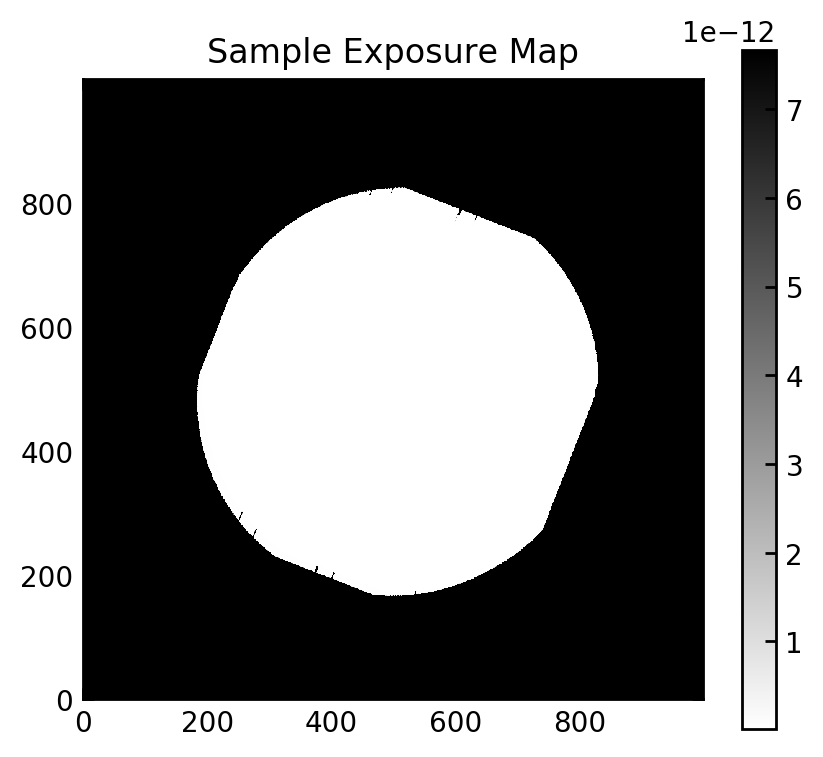

In [105]:
plt.figure(figsize = [5,5], dpi = 200)
plt.imshow(fluxlimit_2d, cmap = 'binary', origin = 'lower')
plt.title("Sample Exposure Map")
plt.colorbar(shrink = 0.9)

In [106]:
# Check to see if any pixels have flux limit lower than break flux
print(np.min(fluxlimit_1d))
print(f_b)

1.3016855436313016e-14
3.67e-15


Text(0, 0.5, 'N (>S)')

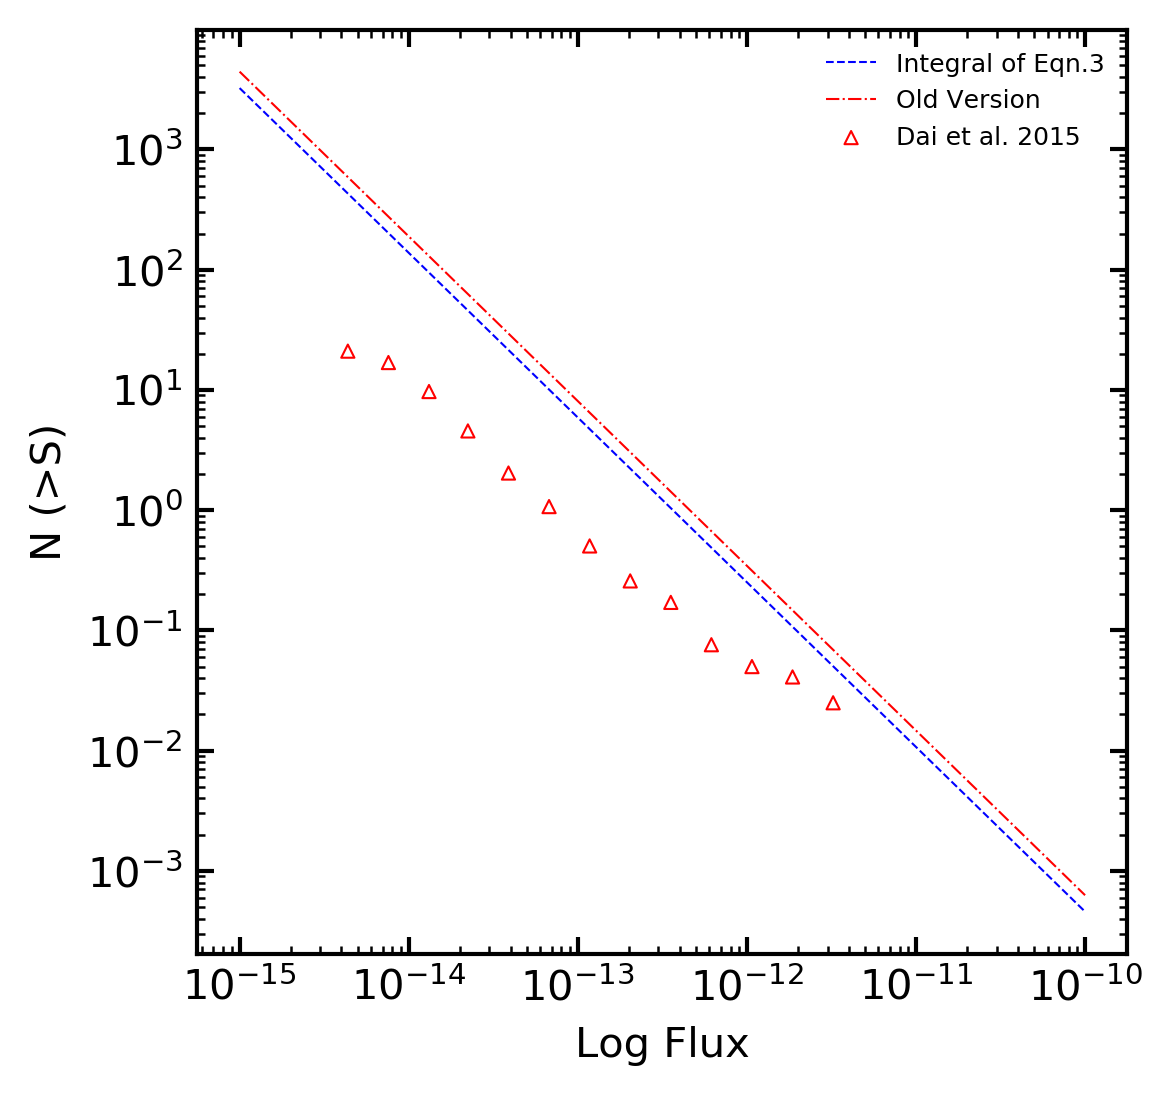

In [34]:
# Try replicating Fig. 18:
plt.figure(figsize = [4,4], dpi = 300)

def f5(x):
    return ((1/s_ref)**-b)*k*((f_b/s_ref)**(b-a))*(-x**(-b+1))


# Data from paper:
n_vals = [21.030, 16.904, 9.701, 4.562, 2.037, 1.071, 0.504, 0.258, 0.171, 0.076, 0.050, 0.041, 0.025] 
log_s = [-14.36, -14.12, -13.88, -13.65, -13.41, -13.17, -12.93, -12.69, -12.45, -12.21, -11.97, -11.73, -11.49]

s_vals = np.power(10,log_s)
# Flux vector
flux_range = np.logspace(-15,-10,1000)
plt.loglog(flux_range,np.abs(f4(flux_range)), color = 'blue',label = 'Integral of Eqn.3', linestyle = '--', linewidth = 0.5)
plt.loglog(flux_range,np.abs(f5(flux_range)), color = 'red',label = 'Old Version', linestyle = '-.', linewidth = 0.5)

plt.scatter(s_vals,n_vals, marker = '^', label = 'Dai et al. 2015', s = 10, facecolor = 'none', edgecolor = 'r', linewidth = .5)
plt.legend(fontsize = 6, frameon = False)
plt.xlabel('Log Flux')
plt.ylabel('N (>S)')


Text(0, 0.5, 'N (>S)')

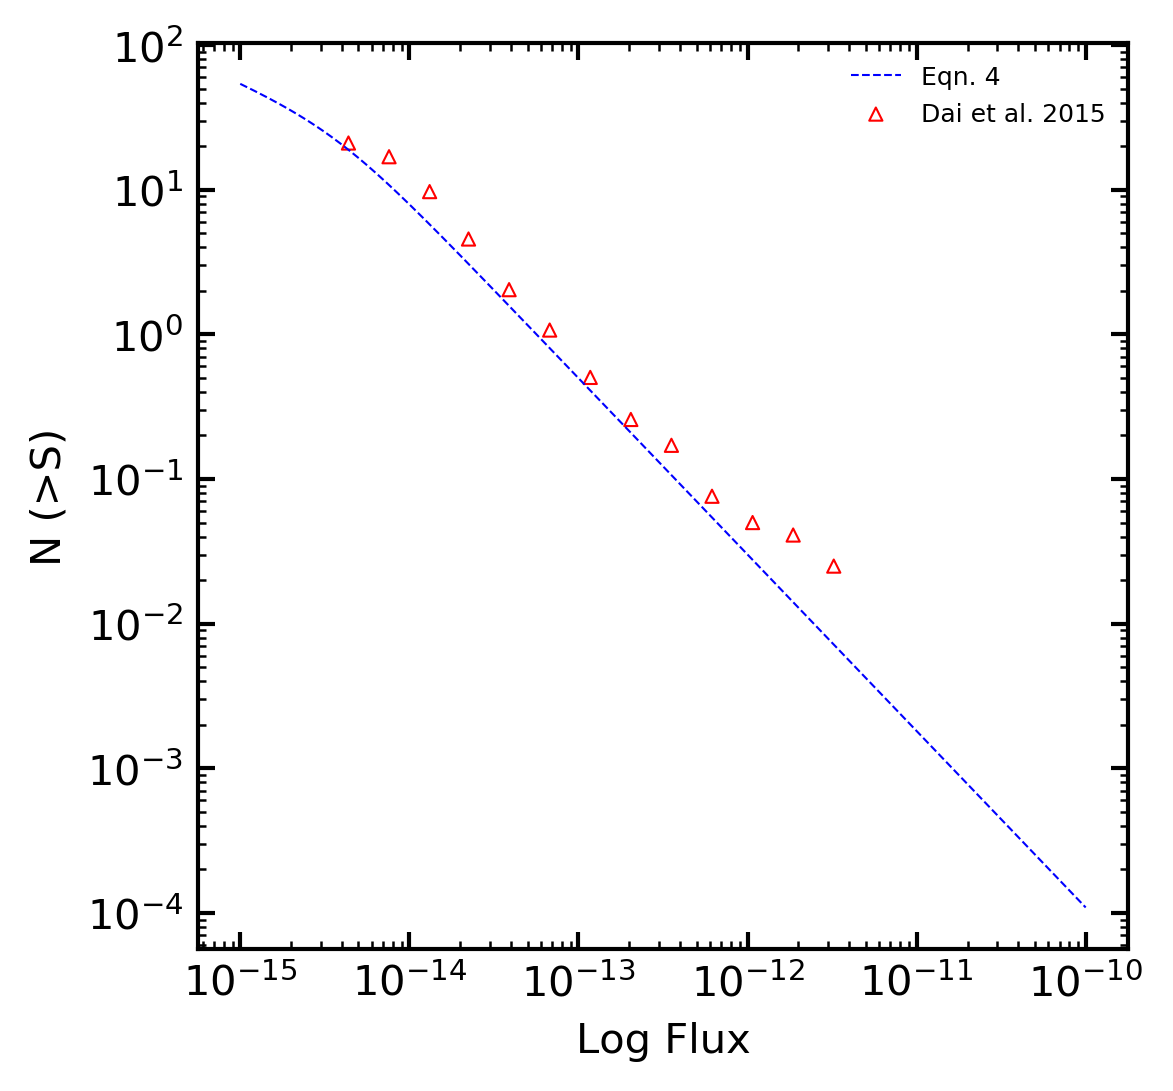

In [108]:
# Try again: Now using eqn 4.
c = 2
k_2 = 28.13
a_2 = 0.52
b_2= 1.22

def f5(x):
    return k_2*(x/f_b)**-a_2 / ((1+(x/f_b)**c)**((b_2-a_2)/c))

plt.figure(figsize = [4,4], dpi = 300)



plt.loglog(flux_range,np.abs(f5(flux_range)), color = 'blue',label = 'Eqn. 4', linestyle = '--', linewidth = 0.5)
plt.scatter(s_vals,n_vals, marker = '^', label = 'Dai et al. 2015', s = 10, facecolor = 'none', edgecolor = 'r', linewidth = .5)
plt.legend(fontsize = 6, frameon = False)
plt.xlabel('Log Flux')
plt.ylabel('N (>S)')

In [109]:
# Determine number of sources per pixel
Npix = np.zeros(len(fluxlimit_1d))
for j in range(0,len(fluxlimit_1d)):
    Npix[j] = np.abs(f4(fluxlimit_1d[j]))

print(Npix)


[0.01542755 0.01542755 0.01542755 ... 0.01542755 0.01542755 0.01542755]


So it looks like when we used our original function, we were over estimating the number of points.

In [110]:
'''
%%%%%%%%%%%%%%%%%%%%%%%%
 Construct weight map
%%%%%%%%%%%%%%%%%%%%%%%%
'''
pixel_angle_sec = (47.1262 / 20)**2 # [square arcseconds]

pixel_angle_deg = (pixel_angle_sec / 3600**2)# Convert to square degrees: 1 deg = 3600"

N_pixel = pixel_angle_deg*Npix # Sources per pixel

In [111]:
np.sum(N_pixel)

10.529683889492594

In [112]:
len(x[here])

19

In [123]:
# Try inspecting ratios again:


pixel_angle_sec = (47.1262 / 20)**2 # [square arcseconds]

pixel_angle_deg = (pixel_angle_sec / 3600**2)# Convert to square degrees: 1 deg = 3600"

runs = 10

ratios = np.zeros(runs)
for i in range(0,runs):
    pixel_angle_sec = (47.1262 / 20)**2 # [square arcseconds]
    pixel_angle_deg = (pixel_angle_sec / 3600**2)
    pix_scale = 47.1262 / 20 # arcseconds / pixel
    # Integrate the broken power law from the paper:
    a = 1.34
    b = 2.37 # +/- 0.01
    f_b = 3.67 * 10 ** (-15) # erg  cm^-2 s^-1
    k = 531.91*10**14 # +/- 250.04; (deg^-2 (erg cm^-2 s^-1)^-1)
    s_ref = 10**-14 # erg cm^-2 s^-1

    def f3(x):
        return (1/(-a+1))*(1/s_ref)**(-a)*k*(x**(-a+1))

    def f4(x):
        return (1/s_ref)**(-b)*k*(f_b/s_ref)**(b-a)*(1/(-b+1))*(x**(-b+1))
    
    # Read in the relevant exposure map:
    here = np.where(field == field_list[i])
    
    if os.path.isfile(path  + field[here][0] +'/expo.fits') == True:
        expmap = path + field[here][0] +'/expo.fits'
        print("Exposure map located")

        
        
    # Read in exposure map with astropy
        hdu_list = fits.open(expmap)
        image_data = hdu_list[0].data
        hdu_list.close()
        exp_map_1d =  image_data.ravel() #Conver exposure map to 1D array for later
        
      # Save reference pixel value for later
        ref_flux =  image_data[500,500]
    
        # Use the interpolated function to extract flux limit based off reference flux
        flux_lim = (func1(ref_flux))
    
        # Find the flux limit for each pixel:
        fluxlimit = np.zeros(len(exp_map_1d))
        for j in range(0,len(fluxlimit)):
            fluxlimit[j] = (func1(exp_map_1d[j]))
            
        fluxlimit_1d = np.asarray(fluxlimit) #convert to numpy array
        fluxlimit_2d = np.reshape(fluxlimit_1d,(-1,len(image_data[0])))
        
        # Determine number of sources per pixel
        Npix = np.zeros(len(fluxlimit_1d))
        for j in range(0,len(fluxlimit_1d)):
            Npix[j] = np.abs(f4(fluxlimit_1d[j]))

        N_pixel = pixel_angle_deg*Npix # Sources per pixel
        
        ratios[i] = (len(x[here])) / int(np.sum(N_pixel))

Exposure map located
Exposure map located
Exposure map located
Exposure map located
Exposure map located
Exposure map located
Exposure map located
Exposure map located


ZeroDivisionError: division by zero

In [121]:
# practice saving weight map to file


array([6.60931908e-09, 6.60931908e-09, 6.60931908e-09, ...,
       6.60931908e-09, 6.60931908e-09, 6.60931908e-09])

Exposure map located
Directory created...
Exposure map 1 created...
random image created


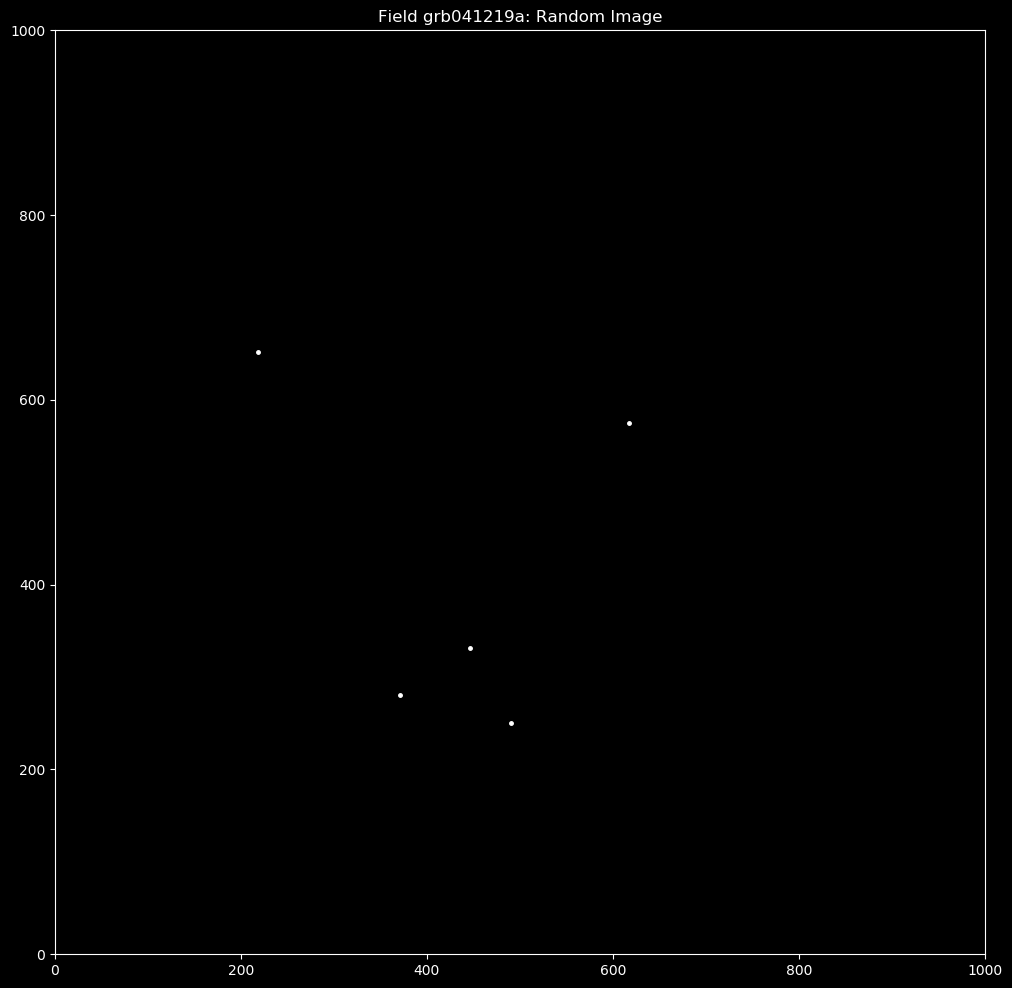

In [42]:
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
#from scipy.integrate import quad
import matplotlib.pyplot as plt
from astropy.io import fits
import os



# Read in AGN table:
path = '/Users/bbonine/ou/research/corr_func/data/'
# Remote version: cat = "/home/bonine/donnajean/research/agn_corr/data/agntable_total.txt"
cat = path + 'agntable_total.txt'
field = np.loadtxt(cat, dtype = str,delimiter = None, skiprows = 1, usecols=(15) , unpack = True)
x,y = np.loadtxt(cat, delimiter = None, skiprows = 1, usecols=(16,17) , unpack = True)


# Read in the flux limit file: 
#lim = '/home/bonine/donnajean/research/agn_corr/data/fluxlimit.txt'
lim = path + 'fluxlimit.txt'
exp, fluxlim = np.loadtxt(lim,skiprows = 1, unpack = True)
exp = np.power(10,exp) #exposure time in log units; convert

# Interpolate the flux values:
func1 = InterpolatedUnivariateSpline(exp,fluxlim) 
xnew = np.linspace(0,10**8, num = 10**7, endpoint = True)
''' Get rid of any duplicates:
#field_list = np.unique(field)
# Select desired AGN in desired field: grb060526, in this case
here = np.where(field == 'grb060124')
x_new = x[here]
y_new = y[here]'''
#index = np.zeros(len(field_list))

#Get rid of any duplicates:
field_list = np.unique(field)

# Create output folder

path1 = "/Users/bbonine/ou/research/corr_func/outputs_debug/"
os.mkdir(path1)




bins = np.logspace(0,3.1,10) #logbins

#Prepare arrays / values to be populated
dd_stack = np.zeros(len(bins))
dr_stack = np.zeros(len(bins))
rr_stack = np.zeros(len(bins))

# tempt to be populated
save_info = np.zeros([1000, 2, 1])

# Total number of data and random points (append in loop)
N_d = 0
N_r = 0
field_count = 0

ratio = []


# Swift Params
pixel_angle_sec = (47.1262 / 20)**2 # [square arcseconds]
pixel_angle_deg = (pixel_angle_sec / 3600**2)
pix_scale = 47.1262 / 20 # arcseconds / pixel

# From Dai et al 2015::
a = 1.34
b = 2.37 # +/- 0.01
f_b = 3.67 * 10 ** (-15) # erg  cm^-2 s^-1
k = 531.91*10**14 # +/- 250.04; (deg^-2 (erg cm^-2 s^-1)^-1)
s_ref = 10**-14 # erg cm^-2 s^-1

# Loop through fields
for i in range(0,1):


    def f3(x):
        return (1/(-a+1))*(1/s_ref)**(-a)*k*(x**(-a+1))

    def f4(x):
        return (1/s_ref)**(-b)*k*(f_b/s_ref)**(b-a)*(1/(-b+1))*(x**(-b+1))
    
    # Read in the relevant exposure map:
    here = np.where(field == field_list[i])
    # Extract source positions in this field:
    data_x = x[here]
    data_y = y[here]
    
    # Check for exposure map
    
    if os.path.isfile(path  + field[here][0] +'/expo.fits') == True:
        expmap = path + field[here][0] +'/expo.fits'
        print("Exposure map located")
        # Make directory for outuput files for this field:
        path2 = path1+field[here][0]
        os.mkdir(path2)
        print("Directory created...")
        
        field_count += 1
        
        # Read in exposure map with astropy
        hdu_list = fits.open(expmap)
        image_data = hdu_list[0].data
        hdu_list.close()
        exp_map_1d =  image_data.ravel() #Conver exposure map to 1D array for later
        
        # Restrict to fields with more than one AGN (necessary for correlation calculation):
    
        # Save reference pixel value for later
        ref_flux =  image_data[500,500]
    
        # Use the interpolated function to extract flux limit based off reference flux
        flux_lim = func1(ref_flux)
    
        # Find the flux limit for each pixel:
        fluxlimit = np.zeros(len(exp_map_1d))
        for j in range(0,len(fluxlimit)):
            fluxlimit[j] = func1(exp_map_1d[j])
            
        fluxlimit_1d = np.asarray(fluxlimit) #convert to numpy array
        fluxlimit_2d = np.reshape(fluxlimit_1d,(-1,len(image_data[0])))
    
        # Determine number of sources per pixel
        Npix = []
        for j in range(0,len(fluxlimit_1d)):
            Npix.append(f4(fluxlimit_1d[j]))
    
        N = np.abs(Npix)
        N_source = pixel_angle_deg*N # Number of sources
        N_norm = N_source / np.max(N_source) # Normalize
    

        # Begin making random image:
        weight_tot = np.sum(N_norm) 
        weight_outer = np.cumsum(N_norm) # 'Outer edge' of pixel weight
        weight_inner = weight_outer - N_norm # 'Inner edge' of pixel weight
        
         # Construct weight map to gerenate random image:
        weight_map = np.reshape(N_norm,(-1,len(image_data[0])))
        plt.style.use('default')
        plt.figure(figsize = [10, 10])
        plt.imshow(weight_map,cmap = 'gray', interpolation = 'none', origin = 'lower')
        plt.colorbar()
        plt.title('Field '+field[here][0]+ ': Normalized sources per pixel')
        #plt.savefig(path2+'/expmap.png')
        plt.close()
        print("Exposure map " + str(i+1) + " created..." )
    
        # Begin making random image:
        weight_tot = np.sum(N_norm) 
        weight_outer = np.cumsum(N_norm) # 'Outer edge' of pixel weight
        weight_inner = weight_outer - N_norm # 'Inner edge' of pixel weight
    
        n_sources = int(np.sum(N_source)) 
        n_dim = 1000 # specify the dimmension of our image
        img2 = np.zeros(n_dim*n_dim)
        var = np.random.uniform(0,weight_tot,n_sources)
        for l in range(0,n_sources):
            for m in range(0,len(img2)):
                if var[l] > weight_inner[m] and var[l] < weight_outer[m]:
                    img2[m] = img2[m] + 1 # specifies flux of pixel.
                    
        # Prepare to save random image array to file:
        rand_img = np.reshape(img2,(n_dim,n_dim))
        save_info[:, 0, i] = rand_img[0] # x vals
        save_info[:, 1, i] = rand_img[1] # y vals
        
        # Plot for visual reference; save to file
        here2 = np.where(rand_img > 0)
        rand_x = here2[0] # image position of x values
        rand_y = here2[1] # image position of y vales
        plt.style.use('dark_background')
        plt.figure(figsize = [12, 12])
        plt.scatter(rand_x,rand_y, marker = '.', color = 'white', s = 25)
        plt.xlim(0,1000)
        plt.ylim(0,1000)
        plt.title('Field '+field[here][0]+ ': Random Image')
        #plt.savefig(path2 + '/rand_img.png'
        

        print('random image created')
        
# Save to file

np.savez(path1+"/random_imgs", info1=save_info)
        

Text(0.5, 1.0, 'Field grb041219a: Data Image')

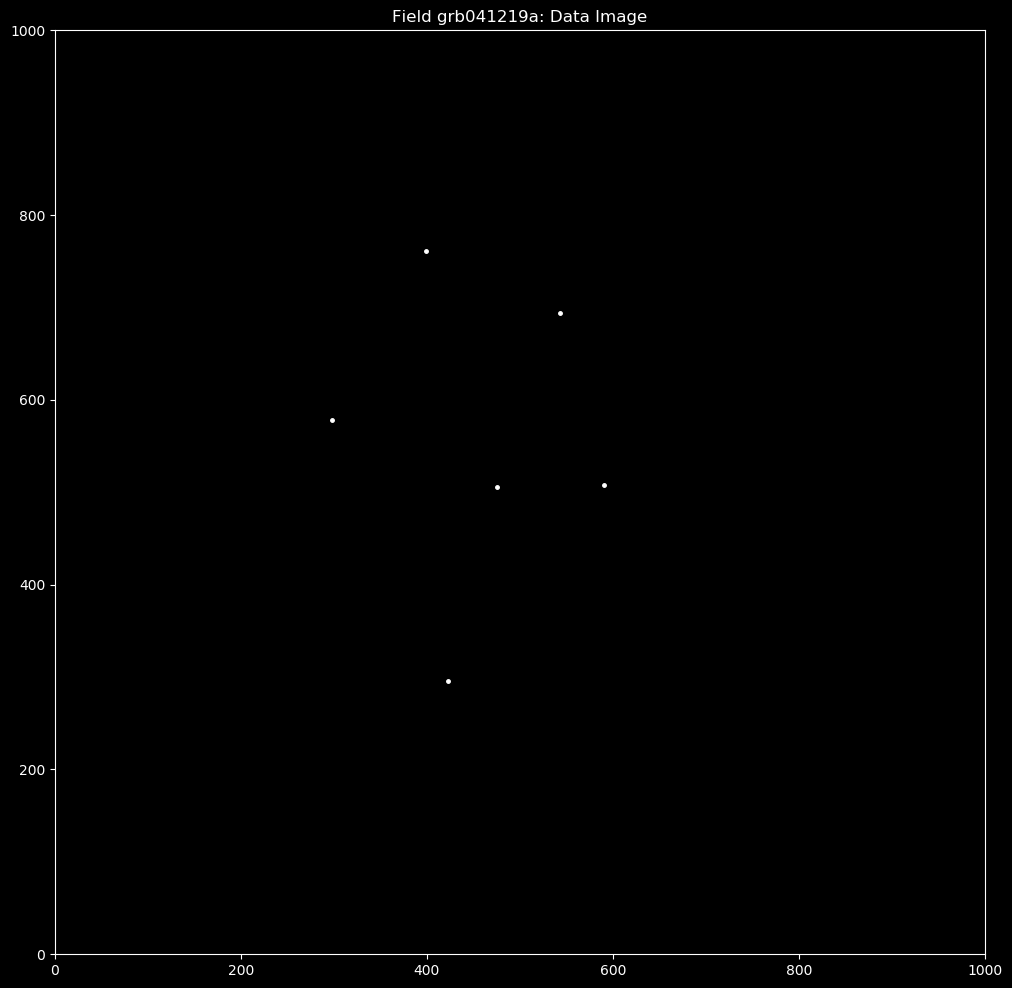

In [41]:
plt.style.use('dark_background')
plt.figure(figsize = [12, 12])
plt.scatter(data_x,data_y, marker = '.', color = 'white', s = 25)
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.title('Field '+field[here][0]+ ': Data Image')

In [44]:
# Practice saving random image arrays to file 
# Try reading in array info 
data = np.load(path1+"/random_imgs.npz") #load file to data object
print(data["info1"])

[[[0.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]

 ...

 [[0.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]


In [46]:
len(data["info1"][0])

2